### This notebook explores Online Moving Window Robust PCA  performance on sonar data

In [4]:
import numpy as np
from PIL import Image, ImageTk
import Tkinter
from timeit import default_timer as timer
import time
from images2gif import writeGif
import scipy.misc
import shutil
import subprocess
from PIL import Image
from IPython import display
from IPython.display import HTML
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.insert(0, os.path.abspath('../../../onlineRPCA/'))
import rpca
from rpca.pcp import pcp
from rpca.mwrpca import mwrpca
from rpca.stoc_rpca  import stoc_rpca
from rpca.omwrpca  import omwrpca
from rpca.omwrpca_cp  import omwrpca_cp

In [5]:
## Reading the Sonar Data
# Reading 2-month sonar time series
import h5py
f = h5py.File('../../data/20150817-20151017_MVBS.h5',"r")
ping_per_day_mvbs = 144
MVBS = np.array(f['MVBS'])
# converting to linear domain
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))
# %%time
# applying pcp to the data in log domain (i.e. the way data comes from ooi)
# L, S, (u,s,v) = pcp(10*np.log10(mvbs_long),maxiter=500, verbose=False,svd_method="exact")

In [6]:
start = timer()
Lhat, Shat, rank, U_list = omwrpca(np.transpose(10*np.log10(mvbs_long)), burnin=10, win_size=10, lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(100))
end = timer()       
print "Running time of omwrpca: %.3f seconds." % (end - start)
np.save("L.npy", Lhat.transpose())
np.save("S.npy", Shat.transpose())

Running time of omwrpca: 4.420 seconds.


In [7]:
Lhat.shape

(15984, 59)

In [8]:
Shat.shape

(15984, 59)

In [9]:

# a function for transforming the data for plotting
def separate_transform_result(D,ori_data,ping_per_day_mvbs,log_opt=1):
    '''
    Separate transformed results into different frequencies and 
    for use with `plot_cmp_data_decomp` and `plot_single_day`
    '''
    D_long = D.reshape((D.shape[0],-1,ori_data.shape[1])).swapaxes(1,2)
    D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
    if log_opt==1:
        D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    else:
        D_plot = D_sep.transpose((0,2,1,3)).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    return D_sep,D_plot


In [10]:
L_sep, L_plot = separate_transform_result(Lhat.T,mvbs,ping_per_day_mvbs,log_opt = 0)
S_sep, S_plot = separate_transform_result(Shat.T,mvbs,ping_per_day_mvbs,log_opt = 0)

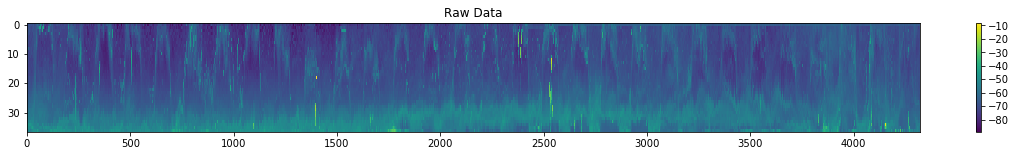

In [11]:
plt.figure(figsize = (20,2))
plt.imshow(10*np.log10(mvbs[2,:,:144*30]), aspect = 'auto')#,vmax = -30,vmin = -80)
plt.colorbar()
plt.title('Raw Data')

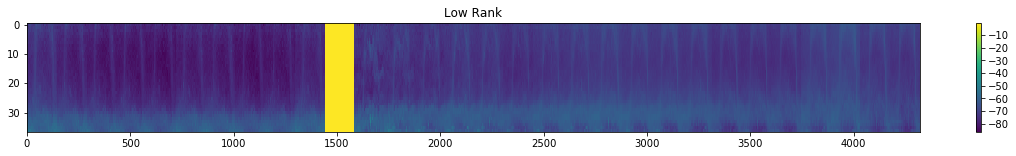

In [12]:
plt.figure(figsize = (20,2))
plt.imshow(L_plot[0,:,:144*30], aspect = 'auto')#,vmax = -30,vmin = -80)
plt.title('Low Rank')
plt.colorbar()

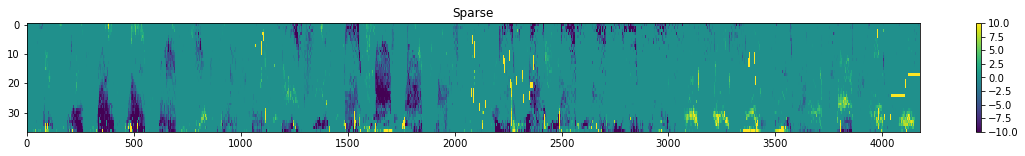

In [13]:
plt.figure(figsize = (20,2))
plt.imshow(S_plot[0,:,144*30:144*59], aspect = 'auto',vmax = 10,vmin = -10)
plt.title('Sparse')
plt.colorbar()

#### Extracting Moving Subspace Components

In [14]:
# they are stored in U_list
len(U_list)

49

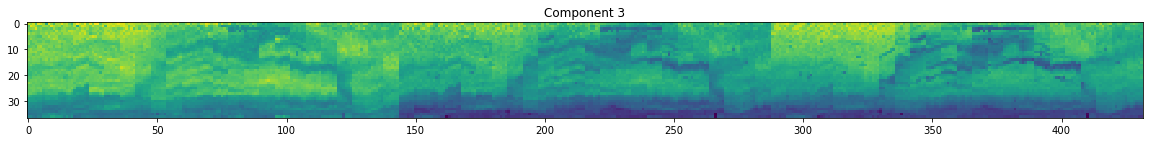

In [15]:
# Let's look at one of them
plt.figure(figsize = (20,2))
plt.imshow(np.array(U_list[0].T).reshape((4,3*ping_per_day_mvbs,-1)).swapaxes(1,2)[3,:,:])
plt.title('Component 3')

In [16]:
np.min(U_list[11] - U_list[10])

-0.00063545088728555674

In [17]:
def plot_comp(V,n_comp,ping_per_day_mvbs,figsize_input,log_opt=1,cax_all=0,cax=np.nan):
    if log_opt==1:
        V = 10*np.ma.log10(V)
    if np.any(np.isnan(cax)):
        cmean_all = np.mean(V)
        cstd_all = np.std(V)
        cmin_all = max((np.min(V),cmean_all-2*cstd_all))
        cmax_all = min((np.max(V),cmean_all+3*cstd_all))
    else:
        cmin_all = cax[0]
        cmax_all = cax[1]

    fig,ax=plt.subplots(n_comp,1,sharex=True,figsize=figsize_input)
    for c in range(n_comp):
        if log_opt==1:
            vlog = 10*np.ma.log10(V[c,:,:])
        else:
            vlog = V[c,:,:]
        cmean = np.mean(V[c,:,:])
        cstd = np.std(V[c,:,:])
        if cax_all==1:
            cmin = cmin_all
            cmax = cmax_all
        else:
            cmin = max((np.min(V[c,:,:]),cmean-2*cstd))
            cmax = min((np.max(V[c,:,:]),cmean+3*cstd))
        im = ax[c].imshow(V[c,::-1,:],aspect='auto',vmin=cmin,vmax=cmax)
        #divider = make_axes_locatable(ax[c])
        #cax = divider.append_axes("right", size="5%", pad=0.1)
        #cbar = plt.colorbar(im,cax=cax)

        ax[c].set_xticks([x*ping_per_day_mvbs+ping_per_day_mvbs/2 for x in range(3)])
        ax[c].set_xticklabels(['38k','120k','200k'])
        ax[c].tick_params('both', length=0)

/Users/valentina/anaconda/envs/onlineRPCA/lib/python2.7/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/valentina/anaconda/envs/onlineRPCA/lib/python2.7/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/valentina/anaconda/envs/onlineRPCA/lib/python2.7/site-packages/matplotlib/colors.py:861: RuntimeWarning: divide by zero encountered in true_divide
  resdat /= (vmax - vmin)


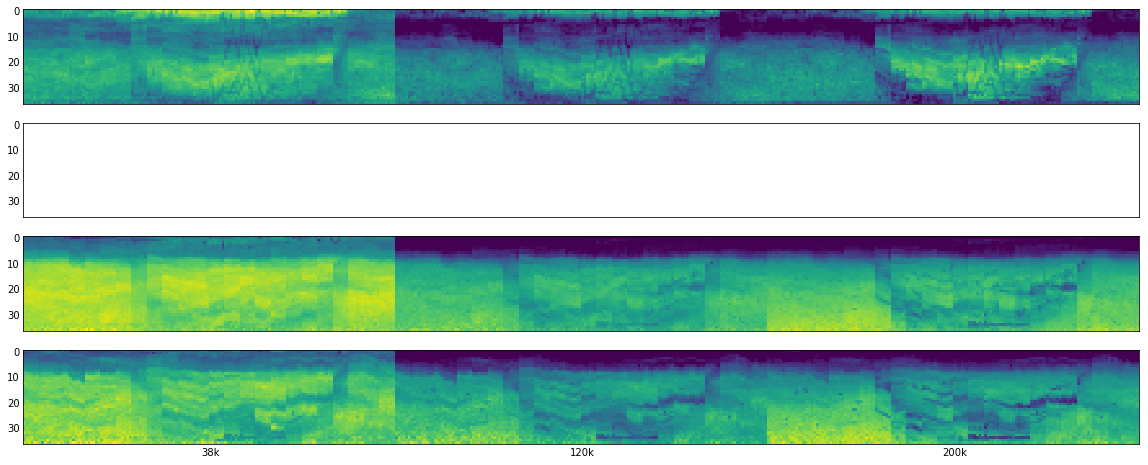

In [18]:
plot_comp(np.array(U_list[10].T).reshape((4,3*ping_per_day_mvbs,-1)).swapaxes(1,2),4,ping_per_day_mvbs,(20,8))

In [19]:
U_list[0]

array([[ 0.00929425, -0.00946762,  0.00955673,  0.00978385],
       [ 0.00847193, -0.00869361,  0.00873235,  0.00885059],
       [ 0.00866351, -0.00888832,  0.00896231,  0.00902915],
       ..., 
       [ 0.00572585, -0.00574494,  0.00573952,  0.00580783],
       [ 0.00551724, -0.00560402,  0.00575966,  0.005846  ],
       [ 0.00542577, -0.00541038,  0.00545138,  0.00542745]])

In [20]:
# the rank estimated from burn-in period
rank

4

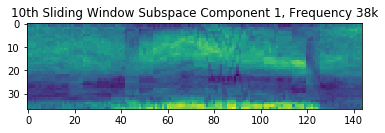

In [21]:
plt.imshow(U_list[10].reshape((3,144,37,4))[0,:,::,0].T)
plt.title("10th Sliding Window Subspace Component 1, Frequency 38k")

In [22]:
# set frequency
f = 2

In [23]:
U_stacked = U_list[0].reshape((3,144,37,4))[0,:,:,0].T
for U in U_list:
    U_stacked = np.hstack((U_stacked,U.reshape((3,144,37,4))[f,:,::-1,0].T))
    

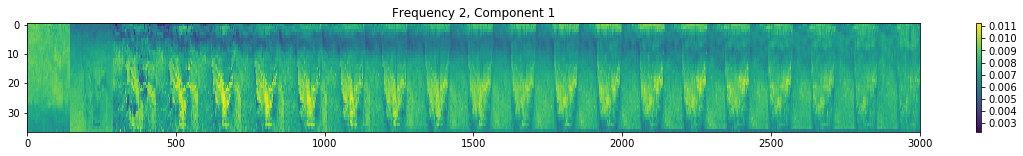

In [24]:
plt.figure(figsize = (20,2))
plt.imshow(U_stacked[:,:3000],aspect = 'auto')
plt.title("Frequency "+str(f)+", Component 1")
plt.colorbar()

In [25]:
U_stacked = U_list[0].reshape((3,144,37,4))[0,:,:,1].T
for U in U_list:
    U_stacked = np.hstack((U_stacked,U.reshape((3,144,37,4))[f,:,:,1].T))

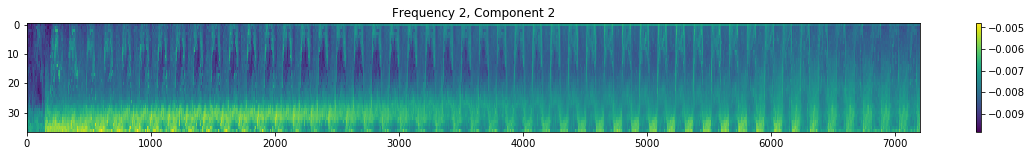

In [26]:
plt.figure(figsize = (20,2))
plt.imshow(U_stacked,aspect = 'auto')
plt.title("Frequency "+str(f)+", Component 2")
plt.colorbar()

In [27]:
U_stacked = U_list[0].reshape((3,144,37,4))[0,:,:,2].T
for U in U_list:
    U_stacked = np.hstack((U_stacked,U.reshape((3,144,37,4))[f,:,:,2].T))

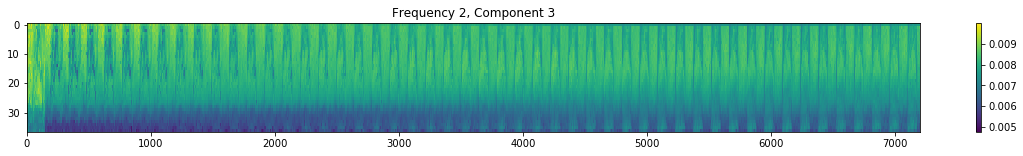

In [28]:
plt.figure(figsize = (20,2))
plt.imshow(U_stacked,aspect = 'auto')
plt.title("Frequency "+str(f)+", Component 3")
plt.colorbar()